## Aggregate the network with an optimization method

In [26]:
import sys
sys.path.append('../src')
import utils
import models as m
import importlib
import matplotlib.pyplot as plt

import importlib.util

read_path = "../DATA/Dev/CapacityFactors_ISONE/NCDataCost_mincost.py"
spec = importlib.util.spec_from_file_location("read", read_path)
read = importlib.util.module_from_spec(spec)
spec.loader.exec_module(read)
importlib.reload(m)
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\g630d\\Documents\\00_Cours\\2024-2025_MIT\\00 Thesis\\Dev\\notebooks\\../src\\utils.py'>

In [28]:
r = read.REDat()

In [29]:
r.ReadREData()

TypeError: REDat.ReadREData() missing 1 required positional argument: 'Setting'

In [14]:
nodes_df, wind_df, solar_df = utils.import_data_county()
nodes_df['Lon'] = -nodes_df['Lon']
TimeSeries = {'wind': wind_df.iloc[:, 1:], 'solar': solar_df.iloc[:, 1:]};

In [15]:
network = utils.Network(nodes_df, TimeSeries)

The 'features' dictionary has been created and can be accessed as '.features'
It is a dictionary with keys for each node in range(0, 67).
Each value is a dictionary with the features of that node.

Example structure:
network.features[0].keys() = dict_keys(['position', 'time_series', 'duration_curves', 'ramp_duration_curves', 'correlation'])

Details:
  - Position: A tuple (latitude, longitude) of that node.
  - Time series: A dictionary with keys for each time series type in dict_keys(['wind', 'solar'])
    and values as the time series itself.
  - Duration Curves: A dictionary with keys for each time series type in dict_keys(['wind', 'solar'])
    and values as the duration curve of the time series.
  - Ramp Duration Curves (RDCs): A dictionary with keys for each time series type dict_keys(['wind', 'solar'])
    and values as the RDC (found by differentiating and subsequently sorting) of the time series.
  - Correlation: A dictionary with keys as tuples of types of time series
    and

In [16]:
node_features = network.features;

In [17]:
n_repr = 10
weights = {
                'position': 1.0,
                'time_series': 1.0,
                'duration_curves': 1.0,
                'rdc': 1.0,
                'intra_correlation': 1.0,
                'inter_correlation': 1.0
            }
aggregator = m.Aggregation(node_features, n_repr)

In [18]:
u_results, z_results = aggregator.optimize(weights)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4557 rows, 4556 columns and 13534 nonzeros
Model fingerprint: 0xaa749c42
Variable types: 0 continuous, 4556 integer (4556 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 6e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve time: 0.05s
Presolved: 4557 rows, 4556 columns, 13534 nonzeros
Variable types: 0 continuous, 4556 integer (4556 binary)
Found heuristic solution: objective 49.0747674

Root relaxation: objective 3.881312e+01, 501 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0            

In [19]:
visuals = utils.Visualization(network, u_results, n_repr, save_fig=True)

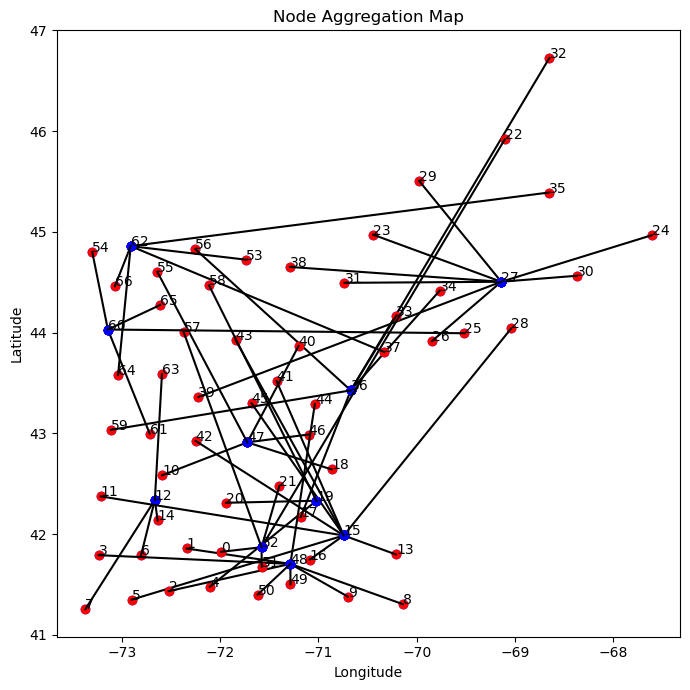

Figure saved as opti_agg_map_67_to_67.png at ../results/


In [20]:
visuals.plot_map()

Clusters:
Cluster 0: Nodes [4]
Cluster 1: Nodes [1, 2, 3, 8, 9, 44, 48, 49, 50]
Cluster 2: Nodes [0, 7, 21, 22, 51, 52, 57]
Cluster 3: Nodes [19, 20, 58]
Cluster 4: Nodes [25, 54, 60, 61, 65]
Cluster 5: Nodes [23, 24, 26, 27, 29, 30, 31, 38, 39]
Cluster 6: Nodes [5, 6, 11, 12, 13, 14, 15, 16, 28, 41, 42, 43, 45]
Cluster 7: Nodes [10, 18, 40, 46, 47, 55]
Cluster 8: Nodes [35, 37, 53, 62, 63, 64, 66]
Cluster 9: Nodes [17, 32, 33, 34, 36, 56, 59]

Cluster Centers:
[4, 48, 52, 58, 60, 27, 15, 47, 66, 36]


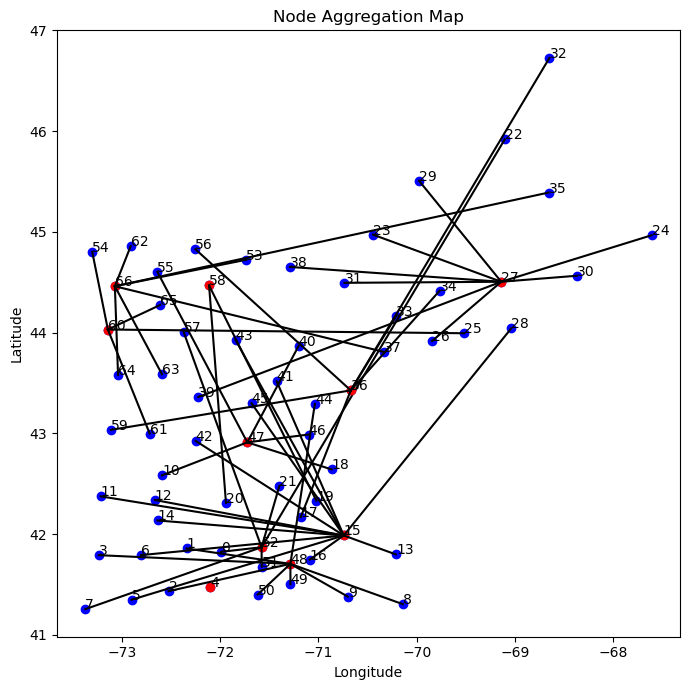

Figure saved as kmedoids_agg_map_67_to_10.png at ../results/


In [21]:
clusters_KMedoids, cluster_centers_KMedoids = aggregator.cluster_KMedoids(weights)

print("Clusters:")
for cluster_id, nodes in clusters_KMedoids.items():
    print(f"Cluster {cluster_id}: Nodes {nodes}")

print("\nCluster Centers:")
print(cluster_centers_KMedoids)

visuals.plot_map(method='kmedoids', kmedoids_medoids=cluster_centers_KMedoids, cluster_mapping=clusters_KMedoids)

In [22]:
original_features = node_features

aggregated_features_KMedoids = {}
for cluster_id, nodes in clusters_KMedoids.items():
    representative = cluster_centers_KMedoids[cluster_id]
    for node in nodes:
        aggregated_features_KMedoids[node] = node_features[representative]

aggregated_features_optimized = {}
for i, selected in enumerate(z_results):
    if selected:
        for j in range(len(u_results)):
            if u_results[j, i] == 1:
                aggregated_features_optimized[j] = node_features[i]

In [23]:
importlib.reload(m)
eval = m.AggregationMetrics(original_features)


Metrics for optimized aggregation:
{'position': 121.5054919693282, 'time_series': 5.683375791595479, 'duration_curves': 1.582093042481093, 'ramp_duration_curves': 0.4669769668599273, 'intra_correlation': 0.036110197891211455, 'inter_correlation': 0.943522147404565}

Metrics for KMedoids clustering:
{'position': 127.87124504384623, 'time_series': 5.596437645403061, 'duration_curves': 1.55482627026951, 'ramp_duration_curves': 0.452588960146999, 'intra_correlation': 0.03741511851518014, 'inter_correlation': 0.9436258259249638}


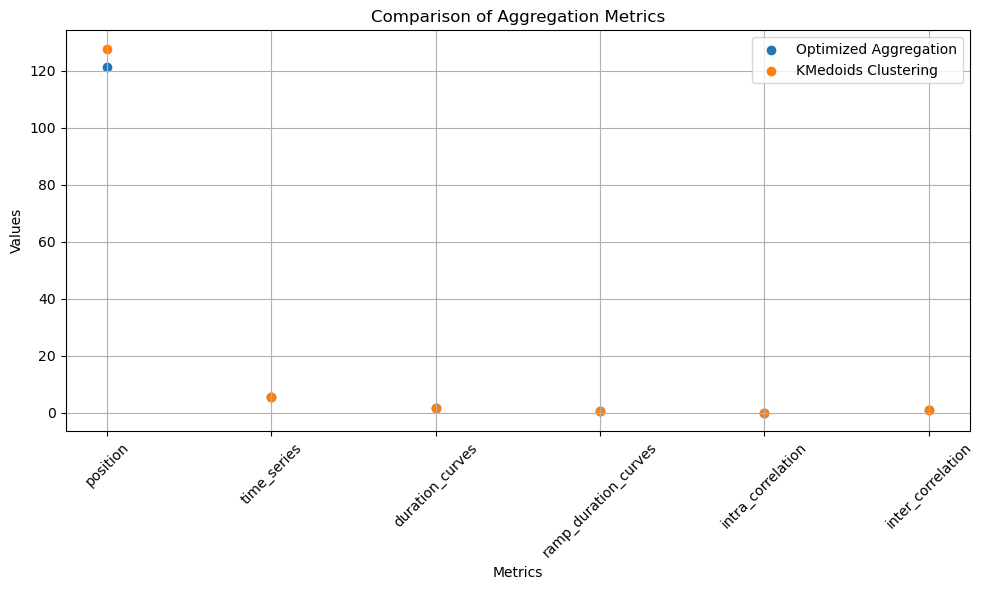

In [24]:
eval_metrics_optimized = eval.compute_metrics(aggregated_features_optimized, type="perso")
eval_metrics_KMedoids = eval.compute_metrics(aggregated_features_KMedoids, type="perso")

print("\nMetrics for optimized aggregation:")
print(eval_metrics_optimized)
print("\nMetrics for KMedoids clustering:")
print(eval_metrics_KMedoids)

metrics = list(eval_metrics_optimized.keys())
optimized_values = list(eval_metrics_optimized.values())
kmedoids_values = list(eval_metrics_KMedoids.values())

# Plotting
x = range(len(metrics))
plt.figure(figsize=(10, 6))
plt.scatter(x, optimized_values, label='Optimized Aggregation', marker='o')
plt.scatter(x, kmedoids_values, label='KMedoids Clustering', marker='o')
plt.xticks(x, metrics, rotation=45)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Aggregation Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
